In [25]:
import pandas as pd
from utils import *

In [26]:
# Load preprocessed data
dataPreprocessed = pd.read_pickle("preprocessedtext.pkl")
dataPreprocessed

,index,sentiment,text,target,processedText
0,670935,0,"@TheRealScarab PA system bugs are a bummer, so...",0,personal assistant system bugs summer sorry
1,649589,0,oh daaamnnn! the firemen ball's on the 14th an...,0,overhead damn firemen ball 14th I cannes signi...
2,2028,0,"I don't want to be cold in April, but I am",0,I want time cold april I ante meridian amplitu...
3,669856,0,@JaredOngie haha its too cold down here bt ot...,0,haha I think think cold instant message fine s...
4,458897,0,Upset I can't find my CHI!,0,upset I find miss chi
...,...,...,...,...,...
139995,860453,4,@lynnnein Lmao I think I'll always have growin...,1,laugh ass I think I grow pains grow
139996,1070764,4,"@marinavorobyev no doubt, we have to support e...",1,doubt time support
139997,978520,4,"now on, gonna have a word of the day todays w...",1,word day todays word hmm apocalypse
139998,1502159,4,@LolaHedoOnline awful and sweaty are two of my...,1,awful sweat miss favorite things lime face


# Split And Tokenize Data

In [109]:
from sklearn.model_selection import train_test_split
# Split data into train, validation, and test sets
df_train, df_test_val, y_train, y_test_val = train_test_split(dataPreprocessed['processedText'], dataPreprocessed.target, test_size=0.3, random_state=0)
df_test, df_val, y_test, y_val = train_test_split(df_test_val, y_test_val, test_size=0.5, random_state=0)

# Tokenize text
textToken = [_text.split() for _text in dataPreprocessed['processedText']]



In [110]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizing and padding the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataPreprocessed['processedText'])
vocab_size = len(tokenizer.word_index) + 1
input_length = 150
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train), maxlen=input_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test), maxlen=input_length)

In [111]:
from keras.layers import Embedding
embedding_dimensions = 300

def createEmbeddingMatrix(model, modelName):
  embedding_matrix = np.zeros((vocab_size, embedding_dimensions))
  for word, i in tokenizer.word_index.items():
    if modelName == 'Glove':
      embedding_value = embedding_vector.get(word)
      if embedding_value is not None:
          embedding_matrix[i] = embedding_value
    else:
      if word in model.wv:
        embedding_matrix[i] = model.wv[word]
  print("Embedded matrix shape for ", modelName ,":", embedding_matrix.shape)
  return embedding_matrix

In [113]:
embedding_vector = {}
f = open('glove.6B.300d.txt')
for line in f:
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

# Advance models

## Creating embedding models

In [114]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(vector_size=embedding_dimensions, window=6, min_count=3, workers=8, epochs=20)
w2v_model.build_vocab(textToken)

In [115]:
from gensim.models import FastText

fasttext_model = FastText(vector_size=embedding_dimensions, window=6, min_count=3, workers=8, epochs=20)
fasttext_model.build_vocab(textToken)

In [116]:
# Embedding layers
embedding_layer_random = Embedding(vocab_size, embedding_dimensions, input_length=input_length, trainable=True)
embedding_layer_word2vec = Embedding(vocab_size, embedding_dimensions, weights=[createEmbeddingMatrix(w2v_model, "Word2vec")], input_length=input_length, trainable=True)
embedding_layer_fasttext = Embedding(vocab_size, embedding_dimensions, weights=[createEmbeddingMatrix(fasttext_model, "FastText")], input_length=input_length, trainable=True)
embedding_layer_glove = Embedding(vocab_size, embedding_dimensions, weights=[createEmbeddingMatrix(embedding_vector, 'Glove')], input_length=input_length, trainable=True)

Embedded matrix shape for  Word2vec : (48850, 300)
Embedded matrix shape for  FastText : (48850, 300)
Embedded matrix shape for  Glove : (48850, 300)


In [117]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Callbacks
callbacks = [ReduceLROnPlateau(monitor='val_loss', verbose=1),
             EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=1)]


In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import tensorflow as tf
#LSTM model definition
def simple_lstm(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model



In [119]:
# Training and evaluating models
import tensorflow as tf
def train_and_evaluate(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train, batch_size=512, epochs=10, verbose=1, validation_split=0.1, callbacks=callbacks)
    evaluation_score = model.evaluate(x_test, y_test, verbose=0)
    return history, evaluation_score

## Random 

In [120]:
# Train and evaluate with Word2Vec
model_random = simple_lstm(embedding_layer_random)
#history_word2vec, score_word2vec = train_and_evaluate(model_word2vec, x_train[:1000], y_train[:1000], x_test[:100], y_test[:100])
history_random, score_random = train_and_evaluate(model_random, x_train, y_train, x_test, y_test)

Epoch 1/10
173/173 [==============================] - 253s 1s/step - loss: 82.1896 - accuracy: 0.6063 - val_loss: 0.6579 - val_accuracy: 0.6457 - lr: 1.0000e-04
Epoch 2/10
173/173 [==============================] - 239s 1s/step - loss: 0.6377 - accuracy: 0.6607 - val_loss: 0.6236 - val_accuracy: 0.6814 - lr: 1.0000e-04
Epoch 3/10
173/173 [==============================] - 238s 1s/step - loss: 0.5951 - accuracy: 0.6928 - val_loss: 0.5984 - val_accuracy: 0.7061 - lr: 1.0000e-04
Epoch 4/10
173/173 [==============================] - 243s 1s/step - loss: 0.5996 - accuracy: 0.7300 - val_loss: 0.6021 - val_accuracy: 0.7152 - lr: 1.0000e-04


## Word2Vec

In [123]:
# Train and evaluate with Word2Vec
model_word2vec = simple_lstm(embedding_layer_word2vec)
#history_word2vec, score_word2vec = train_and_evaluate(model_word2vec, x_train[:1000], y_train[:1000], x_test[:100], y_test[:100])
history_word2vec, score_word2vec = train_and_evaluate(model_word2vec, x_train, y_train, x_test, y_test)

Epoch 1/10
173/173 [==============================] - 241s 1s/step - loss: 0.6626 - accuracy: 0.6440 - val_loss: 0.6140 - val_accuracy: 0.6796 - lr: 1.0000e-04
Epoch 2/10
173/173 [==============================] - 235s 1s/step - loss: 1.5547 - accuracy: 0.6678 - val_loss: 0.6093 - val_accuracy: 0.6396 - lr: 1.0000e-04
Epoch 3/10
173/173 [==============================] - 236s 1s/step - loss: 0.5658 - accuracy: 0.7297 - val_loss: 0.6231 - val_accuracy: 0.7366 - lr: 1.0000e-04


## FastText

In [126]:
# Train and evaluate with FastText
model_fasttext = simple_lstm(embedding_layer_fasttext)
history_fasttext, score_fasttext = train_and_evaluate(model_fasttext, x_train, y_train, x_test, y_test)


Epoch 1/10
173/173 [==============================] - 252s 1s/step - loss: 0.6561 - accuracy: 0.6506 - val_loss: 0.5824 - val_accuracy: 0.7168 - lr: 1.0000e-04
Epoch 2/10
173/173 [==============================] - 241s 1s/step - loss: 0.5558 - accuracy: 0.7322 - val_loss: 0.5325 - val_accuracy: 0.7470 - lr: 1.0000e-04
Epoch 3/10
173/173 [==============================] - 243s 1s/step - loss: 0.4991 - accuracy: 0.7706 - val_loss: 0.5160 - val_accuracy: 0.7503 - lr: 1.0000e-04
Epoch 4/10
173/173 [==============================] - 240s 1s/step - loss: 0.4760 - accuracy: 0.7865 - val_loss: 0.5217 - val_accuracy: 0.7488 - lr: 1.0000e-04


## Glove

In [130]:
# Train and evaluate with Glove
model_glove = simple_lstm(embedding_layer_glove)
history_glove, score_glove = train_and_evaluate(model_glove, x_train, y_train, x_test, y_test)


Epoch 1/10
173/173 [==============================] - 246s 1s/step - loss: 0.6363 - accuracy: 0.6467 - val_loss: 0.5767 - val_accuracy: 0.7072 - lr: 1.0000e-04
Epoch 2/10
173/173 [==============================] - 234s 1s/step - loss: 0.5622 - accuracy: 0.7146 - val_loss: 0.5421 - val_accuracy: 0.7287 - lr: 1.0000e-04
Epoch 3/10
173/173 [==============================] - 239s 1s/step - loss: 0.5347 - accuracy: 0.7317 - val_loss: 0.5266 - val_accuracy: 0.7376 - lr: 1.0000e-04
Epoch 4/10
173/173 [==============================] - 241s 1s/step - loss: 0.5151 - accuracy: 0.7439 - val_loss: 0.5190 - val_accuracy: 0.7436 - lr: 1.0000e-04
Epoch 5/10
173/173 [==============================] - 242s 1s/step - loss: 0.5018 - accuracy: 0.7534 - val_loss: 0.5154 - val_accuracy: 0.7442 - lr: 1.0000e-04
Epoch 6/10
173/173 [==============================] - 236s 1s/step - loss: 0.4882 - accuracy: 0.7614 - val_loss: 0.5094 - val_accuracy: 0.7488 - lr: 1.0000e-04
Epoch 7/10
173/173 [====================

In [16]:
# Visualization function
def plot_accuracy_loss(history, title):
    plt.suptitle(title)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

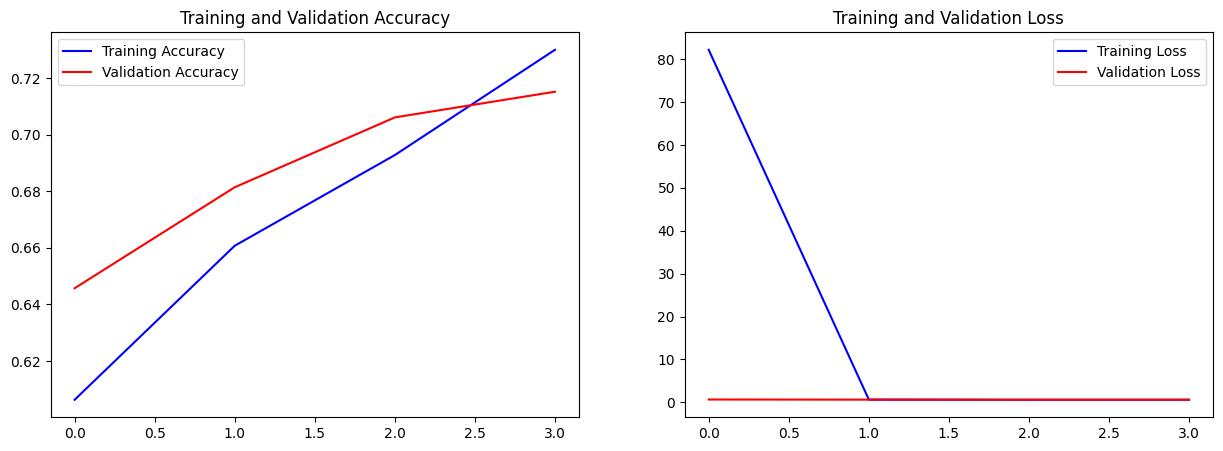

Accuracy: 0.7134285569190979


In [121]:
# Plotting results
plot_accuracy_loss(history_random, 'random Model')
print(f'Accuracy: {score_random[1]}')

<Figure size 640x480 with 0 Axes>

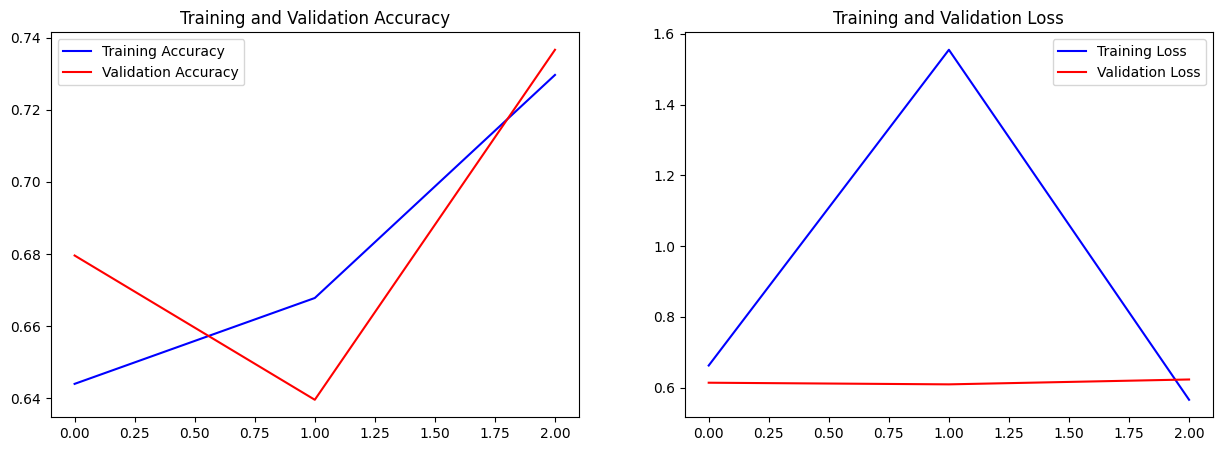

Accuracy: 0.7375237941741943


In [124]:
# Plotting results
plot_accuracy_loss(history_word2vec, 'Word2Vec Model')
print(f'Accuracy: {score_word2vec[1]}')

<Figure size 640x480 with 0 Axes>

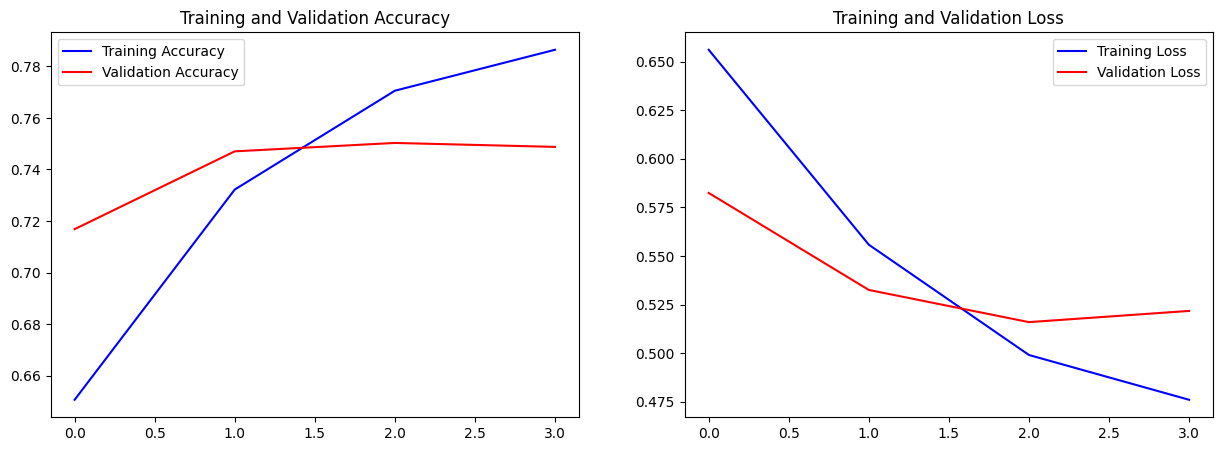

Accuracy: 0.7457619309425354


In [127]:
plot_accuracy_loss(history_fasttext, 'FastText Model')
print(f'Accuracy: {score_fasttext[1]}')

<Figure size 640x480 with 0 Axes>

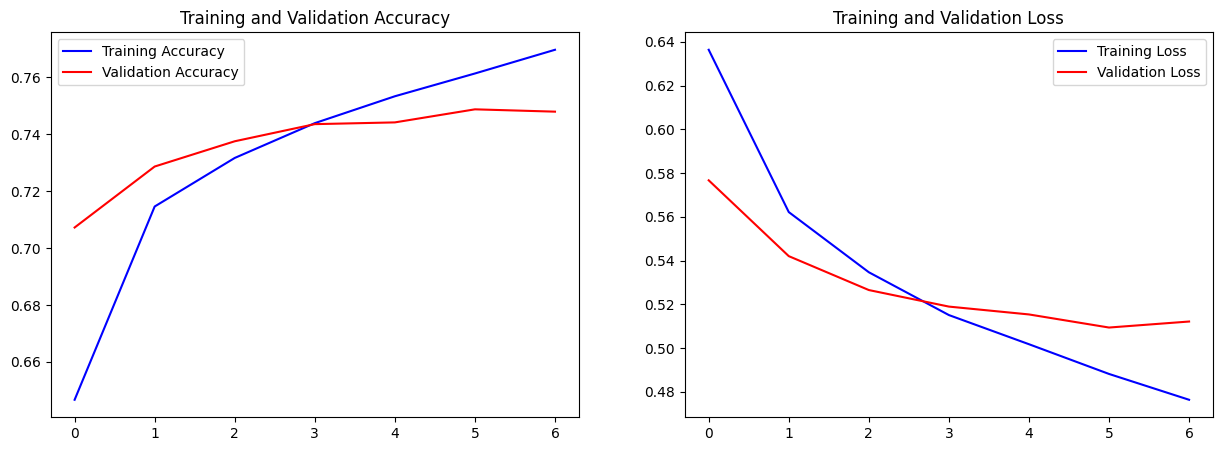

Accuracy: 0.7506190538406372


In [131]:
plot_accuracy_loss(history_glove, 'Glove Model')
print(f'Accuracy: {score_glove[1]}')

## Accuracy

657/657 [==============================] - 44s 66ms/step
Model Accuracy on Test Set: 0.7134285714285714


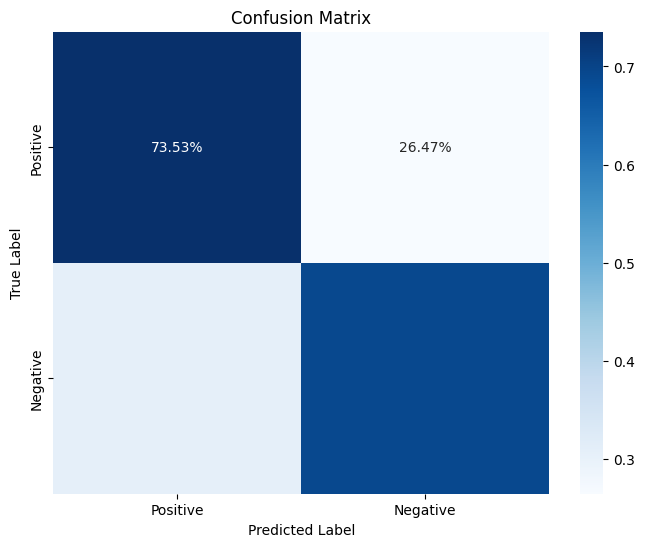

In [122]:
from sklearn.metrics import accuracy_score

y_pred = model_random.predict(x_test)
y_pred_random = np.round(y_pred).flatten() 

accuracy_random = accuracy_score(y_test, y_pred_random)
print(f"Model Accuracy on Test Set: {accuracy_random}")

plot_confusion_matrix(y_test,y_pred_random)


657/657 [==============================] - 44s 66ms/step
Model Accuracy on Test Set: 0.7375238095238095


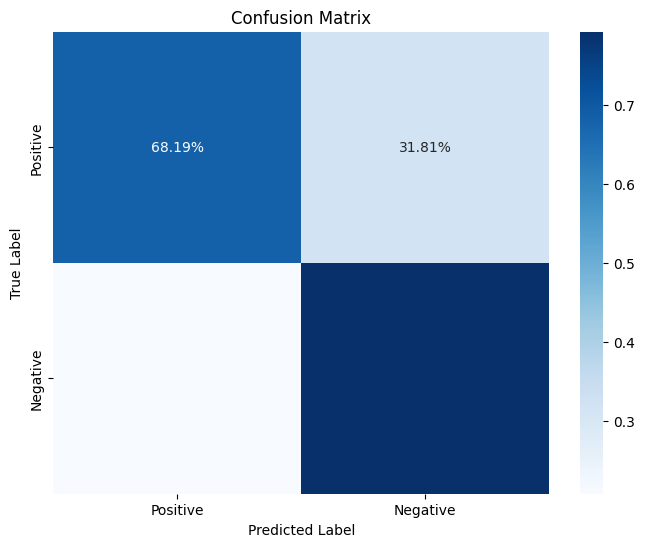

In [125]:
from sklearn.metrics import accuracy_score

y_pred = model_word2vec.predict(x_test)
y_pred_word2vec = np.round(y_pred).flatten() 

accuracy_w2v = accuracy_score(y_test, y_pred_word2vec)
print(f"Model Accuracy on Test Set: {accuracy_w2v}")

plot_confusion_matrix(y_test,y_pred_word2vec)

657/657 [==============================] - 45s 68ms/step
Model Accuracy on Test Set: 0.7457619047619047


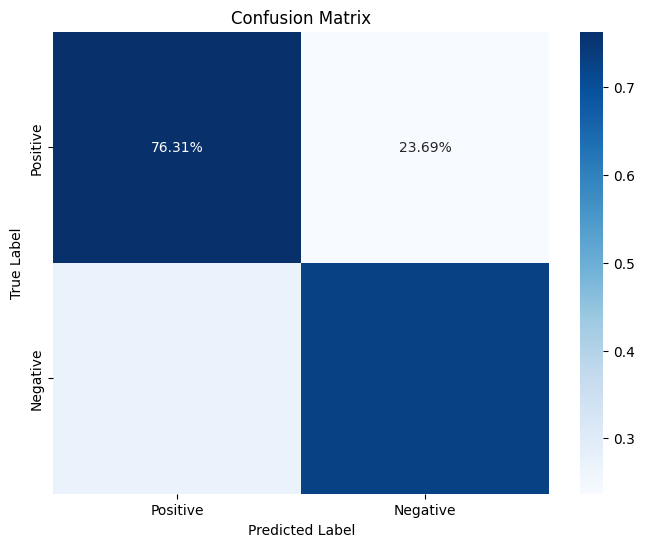

In [129]:
y_pred = model_fasttext.predict(x_test)
y_pred_fasttext = np.round(y_pred).flatten() 

accuracy_fast = accuracy_score(y_test, y_pred_fasttext)
print(f"Model Accuracy on Test Set: {accuracy_fast}")

plot_confusion_matrix(y_test,y_pred_fasttext)

4/4 [==============================] - 1s 58ms/step
Model Accuracy on Test Set: 0.7


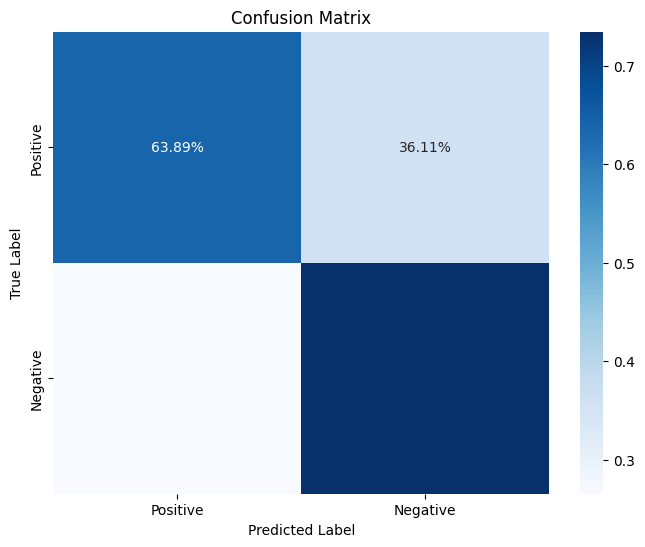

In [132]:
y_pred = model_glove.predict(x_test[:100])
y_pred_glove = np.round(y_pred).flatten() 

accuracy_glove = accuracy_score(y_test[:100], y_pred_glove)
print(f"Model Accuracy on Test Set: {accuracy_glove}")

plot_confusion_matrix(y_test[:100],y_pred_glove)

## Compare the accuracy of the models

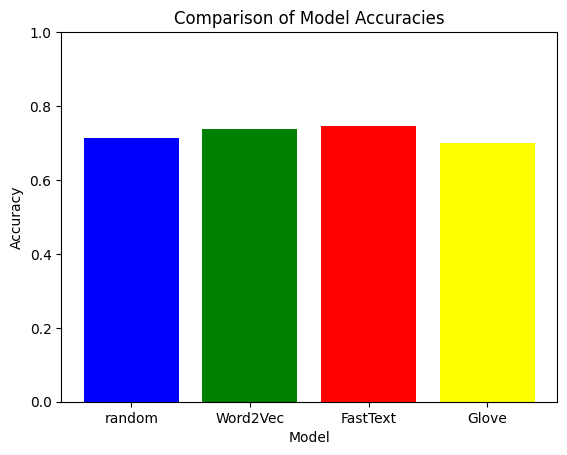

In [134]:
import matplotlib.pyplot as plt


models = ['random', 'Word2Vec', 'FastText', 'Glove']
accuracies = [accuracy_random, accuracy_w2v, accuracy_fast, accuracy_glove]

plt.bar(models, accuracies, color=['blue', 'green', 'red', 'yellow'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 1])  # Assuming accuracy values are between 0 and 1
plt.show()